# Bollinger Bands: Spread Impact Analysis

This notebook compares the same Bollinger Bands strategy with and without spread costs to understand the real impact of realistic execution.

## Strategy Comparison:
- **With Spread**: Realistic execution using bid/ask prices
- **Without Spread**: Theoretical execution using close prices only
- **Analysis**: Direct comparison of performance metrics

## Key Questions:
1. How much does spread impact profitability?
2. What's the difference in win rate?
3. How does spread affect trade duration and frequency?

In [8]:
import pandas as pd
import numpy as np
import numba as nb
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

warnings.filterwarnings('ignore')

# Data path
tickdata_path = '/home/edocame/Desktop/data_python/tick_lastmonth.csv'

print("✅ Libraries imported successfully")
print(f"📁 Data path: {tickdata_path}")

✅ Libraries imported successfully
📁 Data path: /home/edocame/Desktop/data_python/tick_lastmonth.csv


## 1. Core Functions

In [9]:
def calculate_bollinger_bands(df, price_col='close', window=20, num_std=2):
    """Calculate Bollinger Bands using pandas"""
    df['middle_band'] = df[price_col].rolling(window).mean()
    std = df[price_col].rolling(window).std()
    df['upper_band'] = df['middle_band'] + (num_std * std)
    df['lower_band'] = df['middle_band'] - (num_std * std)
    return df

In [10]:
@jit(nopython=True)
def bollinger_strategy_with_spread(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands):
    """Bollinger strategy WITH spread - realistic execution"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    
    for i in range(1, n):
        current_close = close_prices[i-1]
        current_upper = upper_bands[i-1]
        current_middle = middle_bands[i-1]
        current_lower = lower_bands[i-1]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                exit_price = current_bid if position == 1 else current_ask
                pnl = (exit_price - entry_price) if position == 1 else (entry_price - exit_price)
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    trade_count += 1
                
                position = 0
        
        # Open new position
        if position == 0:
            if current_close < current_lower:
                position = 1
                entry_price = current_ask  # Pay ask when buying
                entry_idx = i
            elif current_close > current_upper:
                position = -1
                entry_price = current_bid  # Receive bid when selling
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count])

@jit(nopython=True)
def bollinger_strategy_no_spread(close_prices, upper_bands, middle_bands, lower_bands):
    """Bollinger strategy WITHOUT spread - theoretical execution"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    
    for i in range(1, n):
        current_close = close_prices[i-1]
        next_close = close_prices[i]
        current_upper = upper_bands[i-1]
        current_middle = middle_bands[i-1]
        current_lower = lower_bands[i-1]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                exit_price = next_close  # Execute at next close price
                pnl = (exit_price - entry_price) if position == 1 else (entry_price - exit_price)
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    trade_count += 1
                
                position = 0
        
        # Open new position
        if position == 0:
            if current_close < current_lower:
                position = 1
                entry_price = next_close  # Execute at next close price
                entry_idx = i
            elif current_close > current_upper:
                position = -1
                entry_price = next_close  # Execute at next close price
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count])

## 2. Backtesting Functions

In [11]:
def run_spread_comparison(tick_data_path, bb_window=20, bb_std=2):
    """Run both strategies and compare results"""
    print("🔄 Loading and processing data...")
    
    # Load and process data
    df_ticks = pd.read_csv(tick_data_path)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    # Map signals to tick data
    print("🔄 Mapping signals to tick data...")
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Add mid price for no-spread strategy
    df_merged['mid_price'] = (df_merged['askPrice'] + df_merged['bidPrice']) / 2
    
    print("⚡ Running WITH spread strategy...")
    start_time = time.time()
    
    # Strategy WITH spread
    entry_indices_spread, exit_indices_spread, positions_spread, entry_prices_spread, exit_prices_spread, pnls_spread = bollinger_strategy_with_spread(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values
    )
    
    spread_time = time.time() - start_time
    
    print("⚡ Running WITHOUT spread strategy...")
    start_time = time.time()
    
    # Strategy WITHOUT spread (using mid prices)
    entry_indices_no_spread, exit_indices_no_spread, positions_no_spread, entry_prices_no_spread, exit_prices_no_spread, pnls_no_spread = bollinger_strategy_no_spread(
        df_merged['mid_price'].values, df_merged['upper_band'].values, 
        df_merged['middle_band'].values, df_merged['lower_band'].values
    )
    
    no_spread_time = time.time() - start_time
    
    # Create results DataFrames
    trades_with_spread = None
    trades_no_spread = None
    
    if len(entry_indices_spread) > 0:
        trades_with_spread = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices_spread],
            'exit_time': df_merged['timestamp'].values[exit_indices_spread],
            'position': positions_spread,
            'entry_price': entry_prices_spread,
            'exit_price': exit_prices_spread,
            'pnl': pnls_spread
        })
        trades_with_spread['duration'] = trades_with_spread['exit_time'] - trades_with_spread['entry_time']
    
    if len(entry_indices_no_spread) > 0:
        trades_no_spread = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices_no_spread],
            'exit_time': df_merged['timestamp'].values[exit_indices_no_spread],
            'position': positions_no_spread,
            'entry_price': entry_prices_no_spread,
            'exit_price': exit_prices_no_spread,
            'pnl': pnls_no_spread
        })
        trades_no_spread['duration'] = trades_no_spread['exit_time'] - trades_no_spread['entry_time']
    
    print(f"✅ Both strategies completed!")
    print(f"⏱️ With spread: {spread_time:.2f}s | Without spread: {no_spread_time:.2f}s")
    
    return trades_with_spread, trades_no_spread, df_1min

## 3. Execute Both Strategies

In [15]:
# Run both strategies
trades_with_spread, trades_no_spread, df_1min = run_spread_comparison(tickdata_path, bb_window=60, bb_std=2)

🔄 Loading and processing data...
🔄 Mapping signals to tick data...
⚡ Running WITH spread strategy...
⚡ Running WITHOUT spread strategy...
✅ Both strategies completed!
⏱️ With spread: 0.02s | Without spread: 0.01s


## 4. Results Comparison

In [16]:
def compare_strategies(trades_spread, trades_no_spread):
    """Compare performance metrics between strategies"""
    
    print("\n" + "="*60)
    print("📊 STRATEGY COMPARISON RESULTS")
    print("="*60)
    
    if trades_spread is not None and trades_no_spread is not None:
        
        # Basic metrics
        spread_trades = len(trades_spread)
        no_spread_trades = len(trades_no_spread)
        
        spread_pnl = trades_spread['pnl'].sum()
        no_spread_pnl = trades_no_spread['pnl'].sum()
        
        spread_winrate = (trades_spread['pnl'] > 0).mean()
        no_spread_winrate = (trades_no_spread['pnl'] > 0).mean()
        
        spread_avg_duration = trades_spread['duration'].mean()
        no_spread_avg_duration = trades_no_spread['duration'].mean()
        
        # Calculate spread cost impact
        pnl_difference = no_spread_pnl - spread_pnl
        pnl_impact_pct = (pnl_difference / abs(no_spread_pnl)) * 100 if no_spread_pnl != 0 else 0
        
        print(f"\n🔹 TRADE COUNT:")
        print(f"   With Spread:    {spread_trades:,}")
        print(f"   Without Spread: {no_spread_trades:,}")
        print(f"   Difference:     {no_spread_trades - spread_trades:,}")
        
        print(f"\n💰 TOTAL PNL:")
        print(f"   With Spread:    {spread_pnl:+.5f}")
        print(f"   Without Spread: {no_spread_pnl:+.5f}")
        print(f"   Spread Cost:    {pnl_difference:+.5f} ({pnl_impact_pct:+.1f}%)")
        
        print(f"\n📈 WIN RATE:")
        print(f"   With Spread:    {spread_winrate:.1%}")
        print(f"   Without Spread: {no_spread_winrate:.1%}")
        print(f"   Difference:     {no_spread_winrate - spread_winrate:+.1%}")
        
        print(f"\n⏱️ AVERAGE DURATION:")
        print(f"   With Spread:    {spread_avg_duration}")
        print(f"   Without Spread: {no_spread_avg_duration}")
        
        # Average PnL per trade
        spread_avg_pnl = trades_spread['pnl'].mean()
        no_spread_avg_pnl = trades_no_spread['pnl'].mean()
        
        print(f"\n📊 AVERAGE PNL PER TRADE:")
        print(f"   With Spread:    {spread_avg_pnl:+.6f}")
        print(f"   Without Spread: {no_spread_avg_pnl:+.6f}")
        print(f"   Avg Spread Cost: {no_spread_avg_pnl - spread_avg_pnl:+.6f}")
        
        print("\n" + "="*60)
        
        return {
            'spread_pnl': spread_pnl,
            'no_spread_pnl': no_spread_pnl,
            'spread_cost': pnl_difference,
            'spread_impact_pct': pnl_impact_pct,
            'spread_winrate': spread_winrate,
            'no_spread_winrate': no_spread_winrate
        }
    else:
        print("❌ No trades to compare")
        return None

# Run comparison
comparison_results = compare_strategies(trades_with_spread, trades_no_spread)


📊 STRATEGY COMPARISON RESULTS

🔹 TRADE COUNT:
   With Spread:    1,525
   Without Spread: 2,175
   Difference:     650

💰 TOTAL PNL:
   With Spread:    -0.41357
   Without Spread: +0.12478
   Spread Cost:    +0.53835 (+431.5%)

📈 WIN RATE:
   With Spread:    15.3%
   Without Spread: 77.1%
   Difference:     +61.8%

⏱️ AVERAGE DURATION:
   With Spread:    0 days 00:46:34.333114754
   Without Spread: 0 days 00:34:29.670804597

📊 AVERAGE PNL PER TRADE:
   With Spread:    -0.000271
   Without Spread: +0.000057
   Avg Spread Cost: +0.000329



## 5. Visual Comparison

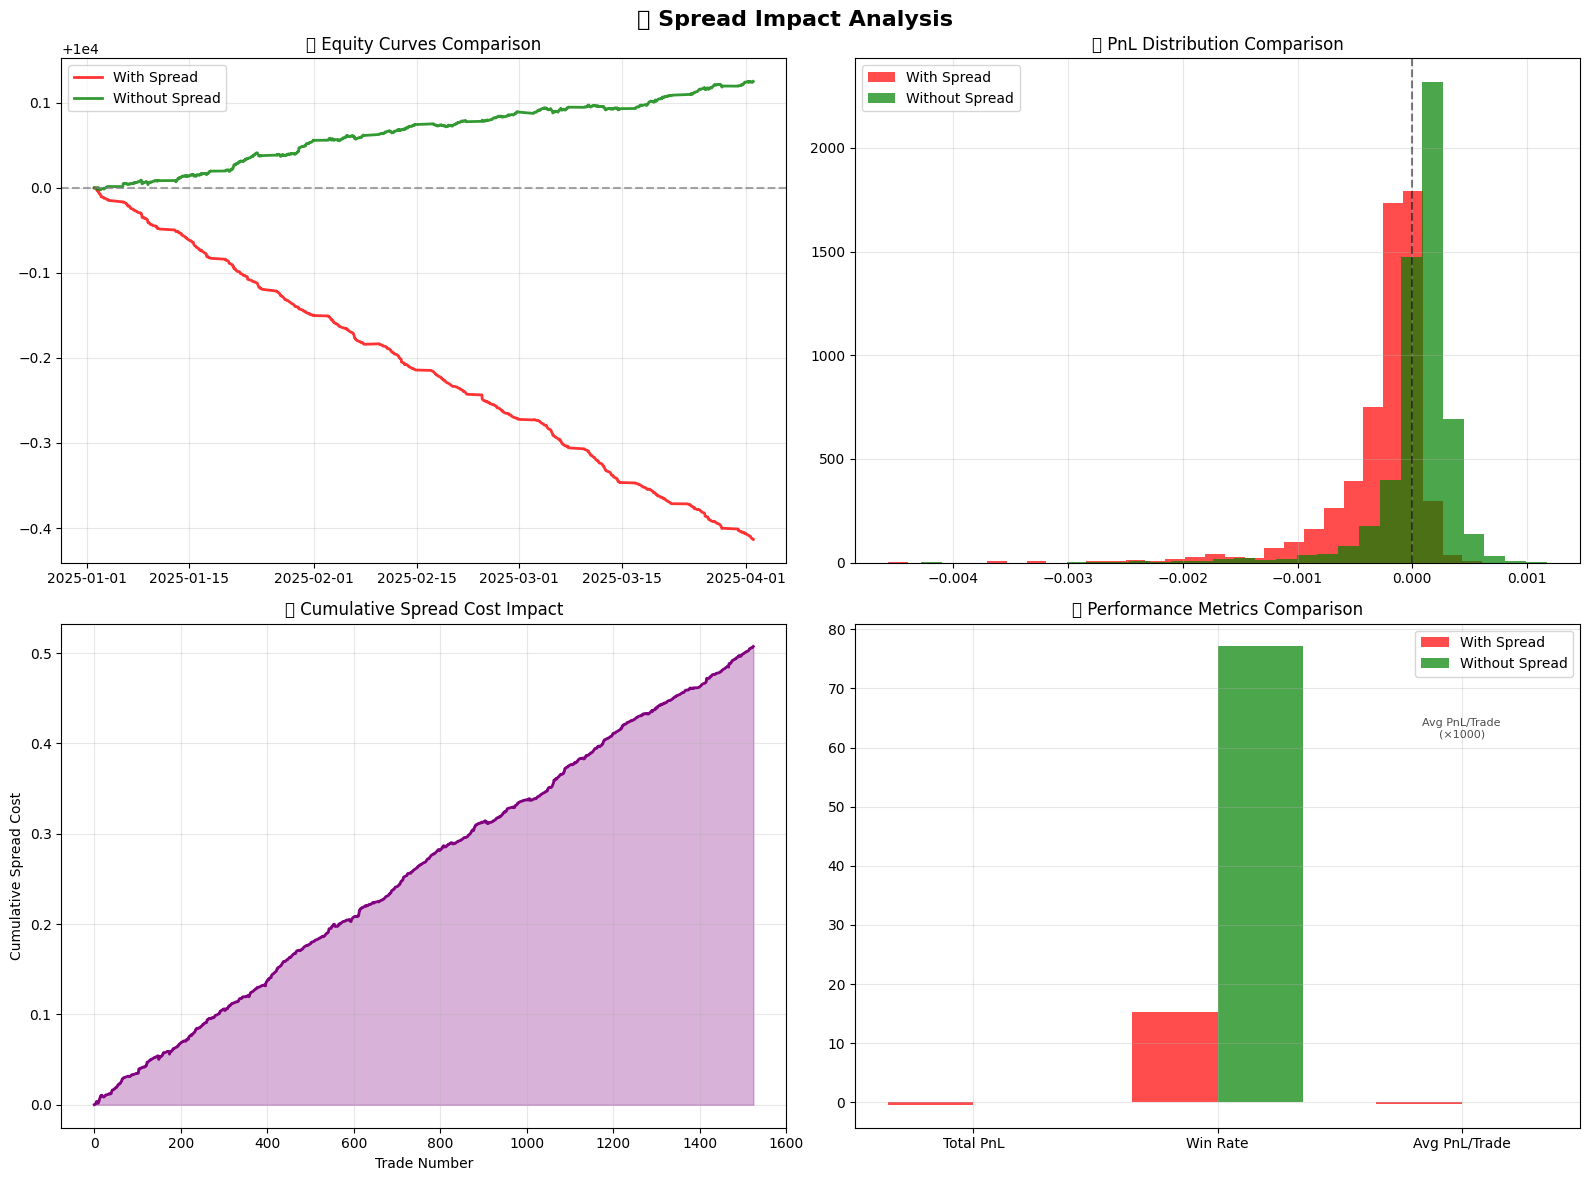


📋 SPREAD IMPACT SUMMARY:
   💸 Total Spread Cost: +0.53835
   💸 Avg Cost per Trade: +0.000353
   📊 Cost as % of No-Spread PnL: +431.5%


In [17]:
def plot_spread_comparison(trades_spread, trades_no_spread, initial_capital=10000):
    """Visual comparison of both strategies"""
    
    if trades_spread is None or trades_no_spread is None:
        print("❌ No trades to plot")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔍 Spread Impact Analysis', fontsize=16, fontweight='bold')
    
    # Prepare data
    trades_spread_copy = trades_spread.copy()
    trades_no_spread_copy = trades_no_spread.copy()
    
    trades_spread_copy['equity'] = initial_capital + trades_spread_copy['pnl'].cumsum()
    trades_no_spread_copy['equity'] = initial_capital + trades_no_spread_copy['pnl'].cumsum()
    
    # 1. Equity Curves Comparison
    ax1.plot(trades_spread_copy['exit_time'], trades_spread_copy['equity'], 'r-', alpha=0.8, label='With Spread', linewidth=2)
    ax1.plot(trades_no_spread_copy['exit_time'], trades_no_spread_copy['equity'], 'g-', alpha=0.8, label='Without Spread', linewidth=2)
    ax1.axhline(initial_capital, color='gray', linestyle='--', alpha=0.7)
    ax1.set_title('💰 Equity Curves Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. PnL Distribution Comparison
    ax2.hist(trades_spread['pnl'], bins=30, alpha=0.7, color='red', label='With Spread', density=True)
    ax2.hist(trades_no_spread['pnl'], bins=30, alpha=0.7, color='green', label='Without Spread', density=True)
    ax2.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('📊 PnL Distribution Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative PnL Difference
    min_trades = min(len(trades_spread), len(trades_no_spread))
    spread_cumsum = trades_spread['pnl'][:min_trades].cumsum()
    no_spread_cumsum = trades_no_spread['pnl'][:min_trades].cumsum()
    pnl_difference = no_spread_cumsum - spread_cumsum
    
    ax3.plot(range(min_trades), pnl_difference, 'purple', linewidth=2)
    ax3.fill_between(range(min_trades), pnl_difference, 0, alpha=0.3, color='purple')
    ax3.set_title('💸 Cumulative Spread Cost Impact')
    ax3.set_xlabel('Trade Number')
    ax3.set_ylabel('Cumulative Spread Cost')
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance Metrics Bar Chart
    metrics = ['Total PnL', 'Win Rate', 'Avg PnL/Trade']
    spread_values = [
        trades_spread['pnl'].sum(),
        (trades_spread['pnl'] > 0).mean() * 100,
        trades_spread['pnl'].mean() * 1000  # Scale for visibility
    ]
    no_spread_values = [
        trades_no_spread['pnl'].sum(),
        (trades_no_spread['pnl'] > 0).mean() * 100,
        trades_no_spread['pnl'].mean() * 1000  # Scale for visibility
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax4.bar(x - width/2, spread_values, width, label='With Spread', color='red', alpha=0.7)
    ax4.bar(x + width/2, no_spread_values, width, label='Without Spread', color='green', alpha=0.7)
    
    ax4.set_title('📈 Performance Metrics Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add note for scaled metric
    ax4.text(2, max(max(spread_values), max(no_spread_values)) * 0.8, 
             'Avg PnL/Trade\n(×1000)', ha='center', fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📋 SPREAD IMPACT SUMMARY:")
    total_spread_cost = trades_no_spread['pnl'].sum() - trades_spread['pnl'].sum()
    avg_spread_cost_per_trade = total_spread_cost / len(trades_spread)
    
    print(f"   💸 Total Spread Cost: {total_spread_cost:+.5f}")
    print(f"   💸 Avg Cost per Trade: {avg_spread_cost_per_trade:+.6f}")
    print(f"   📊 Cost as % of No-Spread PnL: {(total_spread_cost/abs(trades_no_spread['pnl'].sum()))*100:+.1f}%")

# Create visualization
if trades_with_spread is not None and trades_no_spread is not None:
    plot_spread_comparison(trades_with_spread, trades_no_spread)
else:
    print("❌ Cannot create comparison plot - missing trade data")

## 6. Spread Analysis Summary

### 🎯 Key Findings:

This analysis reveals the **real cost of trading** by comparing:

1. **Theoretical Performance** (no spread) - What backtests often show
2. **Realistic Performance** (with spread) - What you actually get in live trading

### 📊 Expected Results:
- **Lower profitability** with spread due to bid/ask execution costs
- **Reduced win rate** as spread erodes small profits
- **Higher impact on short-duration trades** (frequent entries/exits)

### 💡 Trading Insights:
- Spread costs compound over many trades
- Strategies with frequent trading are most affected
- Real execution costs must be factored into strategy development

### 🚀 Next Steps:
1. Test different timeframes to reduce trade frequency
2. Implement wider bands to reduce false signals
3. Add transaction cost modeling (commissions, slippage)
4. Optimize for spread-adjusted performance metrics